In [1]:
import sklearn.ensemble

from preprocessing.data_cleaning import get_cleaned_data, split_csv, get_features_label
from preprocessing.encoding import encode_data
from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_patientwise_errors, plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.midterm_exploration import plot_feature_against_diagnosis
from utils.utils import log_features
from modeling.mrmr import perform_mrmr

In [2]:
df = encode_data(get_cleaned_data())
df = df[df["P1_PT_TYPE"] != 3]
log_features(df)
blood, clinical = split_csv(df)

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

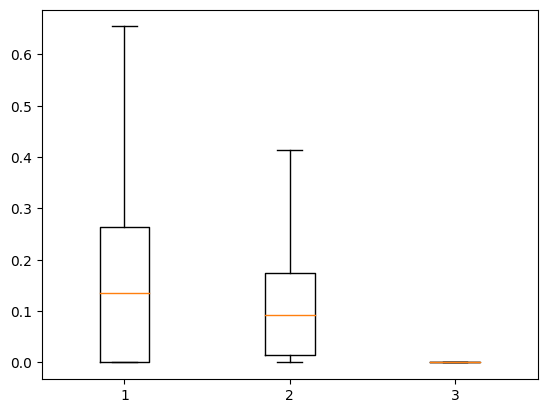

In [3]:
plot_patientwise_errors(
    df,
    ["C1_WAIS3_DIGTOT", "B1_BMI", "RBM_Insulin"],
    ["Race", "WAIS3 Digits Score", "BMI", "Insulin"],
    png="Patientwise Errors"
)

In [4]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

ValueError: Length mismatch: Expected axis has 3 elements, new values have 4 elements

In [5]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

KeyError: "['RBM_Rule_Based_Medicine'] not in index"

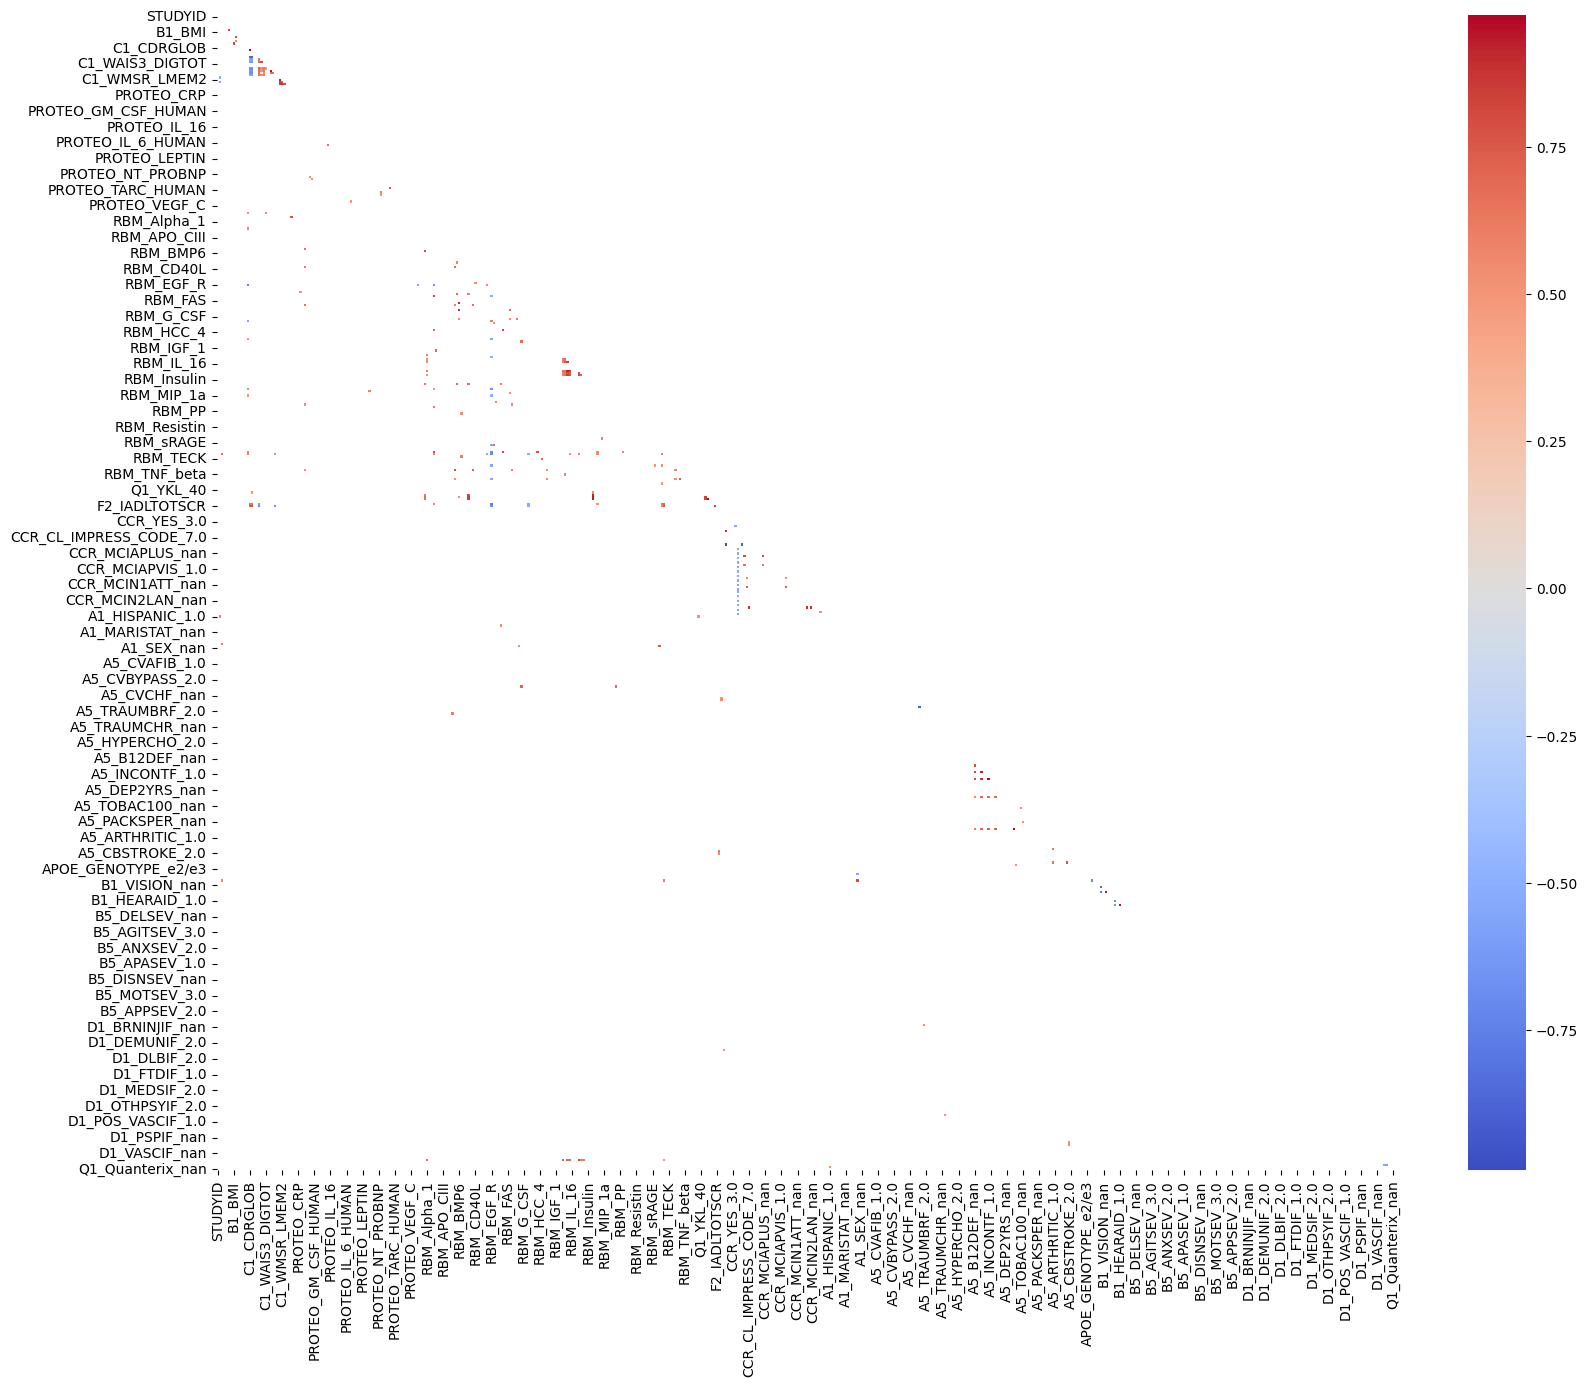

In [6]:
plot_correlations(df)

In [34]:
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier
def test_mrmr_model(df: pd.DataFrame):
    """
    Runs an elastic-net model on the input dataframe, using "P1_PT_TYPE" as the label.

    Args:
        df: The cleaned and encoded TARCC dataset.

    Returns:

    """
    LABEL = 'P1_PT_TYPE'
    X = df.drop(LABEL, axis=1).values
    y = df[LABEL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    test_model = HistGradientBoostingClassifier().fit(X_train, y_train)

    predictions = test_model.predict(X_test)

    return f1_score(y_test, predictions, average="micro")

In [42]:
import pandas as pd
import numpy as np

y, X = get_features_label(df)
y = pd.Series(y)
(features, score, redundancy_matrix) = perform_mrmr(X, y, X.shape[1], scr = True)
score = score.sort_values(ascending=False)
score = score.reset_index()

pairs = {}
for num_features in range(1,X.shape[1]):
    print(num_features)
    test_df = df[score['index'][:num_features]]
    test_df["P1_PT_TYPE"] = df["P1_PT_TYPE"]
    micro_f1_score = test_mrmr_model(test_df)
    pairs[num_features] = micro_f1_score

Text(0, 0.5, 'Micro F1 Score')

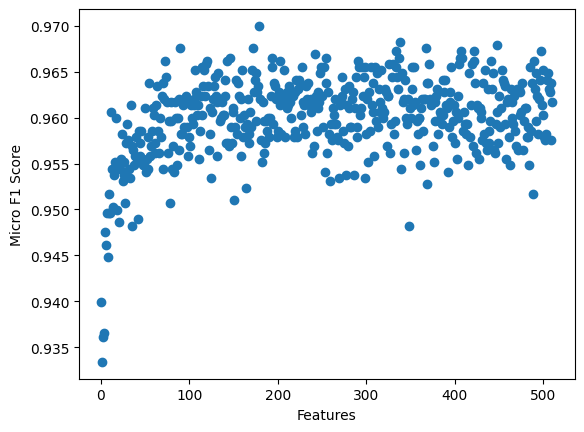

In [43]:
import matplotlib.pyplot as plt
plt.scatter(list(pairs.keys()),list(pairs.values()))
plt.xlabel('Features')
plt.ylabel('Micro F1 Score')

In [ ]:
plot_feature_against_diagnosis(
    blood,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical,
    "C1_MMSE",
    title="MMSE Score by Diagnosis",
    ylabel="MMSE Score",
    png="MMSE Score by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical,
    "C1_CDRSUM",
    title="CDR Score by Diagnosis",
    ylabel="CDR Score",
    png="CDR Score by Diagnosis"
)

temp = clinical[clinical["P1_PT_TYPE"] == 2]
temp["C1_CDRSUM"].value_counts()

In [ ]:
import pandas as pd
label_encoded_df = pd.get_dummies(blood, columns=["P1_PT_TYPE"])

correlations = blood.corr().abs().unstack()
ad_correlations = correlations["P1_PT_TYPE"].sort_values()
print(ad_correlations.index[:100])